In [4]:
import os
import logging
import time
import psycopg2

import pandas as pd
import numpy as np 
from sqlalchemy import create_engine

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
 

def connect_postgres():
    database = os.environ['POSTGRES_DB']
    user = os.environ['POSTGRES_USER']
    password = os.environ['POSTGRES_PASSWORD']
    host = os.environ['POSTGRES_SERVER']
    port = 5432

    exc, conn, engine = None, None, None

    for _ in range(5):
        try:
            conn = psycopg2.connect(
                database=database, user=user, password=password, host=host, port=port)
        except Exception as e:
            logging.warning("Error connecting to postgres, will retry in 3 sec: %s", e)
            time.sleep(3)
            exc = e
        else:
            logging.info("Connected...")
            logging.info("Everything goes well from Postgres, you're a fu*** pro...")
            
            engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                user, password, host, port, database
            ))
            break
    else:
        logging.error("Unable to connect to  %s DB", database)
        raise exc
    
    return [conn, engine]


In [5]:
[conn, engine] = connect_postgres()

INFO:root:Connected...
INFO:root:Everything goes well from Postgres, you're a fu*** pro...


In [11]:
df = pd.read_sql("""
SELECT DISTINCT
	code, bajos_rendimientos,
DATE_PART('year', to_date(SUBSTRING(code::text, 1, 4)::text, 'YYYY')) - DATE_PART('year', student.birth_date::date) as age,
    per_cancelados, m_tesis, m_activo, m_grado, sexo, estrato
    --trans_copy_code_id, count(trans_copy_code_id) as count
    --string_agg(trans_copy_code_id::character varying, ', ') as books
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
	trans_location_code_id = 5 AND
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3340' AND
    year IN (2000) AND
	trans_type_code IN ('ISS') AND
    --code IN (199713183, 198224610) AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id


""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
df_iss = pd.read_sql("""
SELECT
	copytransaction.id, code, trans_tittle_code_id, trans_date_id as date_iss
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
	trans_location_code_id = 5 AND
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3340' AND
    year IN (2000) AND
	trans_type_code IN ('ISS') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_tittle_code_id, trans_date_id, trans_type_code, id

""", con=conn)

df_ret = pd.read_sql("""
SELECT
    code, trans_tittle_code_id, trans_date_id as date_ret
FROM
	public.copytransaction, public.transactiontype, public.copy, public.student, public.date
WHERE
	trans_location_code_id = 5 AND
    sede = 0 AND
    jornada = 'DIU' AND
    program = '3340' AND
    year IN (2000) AND
	trans_type_code IN ('RET') AND
	trans_date_id = date.id AND
	trans_copy_code_id = copy.id AND
	trans_borrower_code = student.id AND
	trans_type_id = transactiontype.id

ORDER BY code, trans_tittle_code_id, trans_date_id, trans_type_code

""", con=conn)

/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/opt/app/.venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
df = df.set_index('code')
df = df.loc[(df['age']  <= 40) & (df['age']  >= 15)]
df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
df = df.astype({col: 'int32' for col in df.select_dtypes('float64').columns})
df = df.astype({col: 'int32' for col in df.select_dtypes('bool').columns})
df

,bajos_rendimientos,age,per_cancelados,m_tesis,m_activo,m_grado,sexo,estrato
code,,,,,,,,
199001027,0,19,0,0,0,1,F,2
199101209,0,21,0,0,0,1,F,2
199101244,0,19,0,0,0,1,F,2
199113169,0,19,0,0,0,1,M,2
199115974,0,19,0,0,0,1,M,2
...,...,...,...,...,...,...,...,...
200132085,0,18,0,0,0,1,M,2
200223011,0,28,0,0,0,0,M,2
200243848,0,22,0,0,0,0,M,2


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 199001027 to 201026922
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bajos_rendimientos  272 non-null    int32 
 1   age                 272 non-null    int32 
 2   per_cancelados      272 non-null    int32 
 3   m_tesis             272 non-null    int32 
 4   m_activo            272 non-null    int32 
 5   m_grado             272 non-null    int32 
 6   sexo                272 non-null    object
 7   estrato             272 non-null    int32 
dtypes: int32(7), object(1)
memory usage: 11.7+ KB


In [15]:
bins= [15,20,25,30,40]
labels = ['15-20','20-25','25-30','30-40']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df.drop('age', axis=1, inplace=True)
df.dropna(inplace=True)
df

,bajos_rendimientos,per_cancelados,m_tesis,m_activo,m_grado,sexo,estrato,age_group
code,,,,,,,,
199001027,0,0,0,0,1,F,2,15-20
199101209,0,0,0,0,1,F,2,20-25
199101244,0,0,0,0,1,F,2,15-20
199113169,0,0,0,0,1,M,2,15-20
199115974,0,0,0,0,1,M,2,15-20
...,...,...,...,...,...,...,...,...
200132085,0,0,0,0,1,M,2,15-20
200223011,0,0,0,0,0,M,2,25-30
200243848,0,0,0,0,0,M,2,20-25


In [16]:
# investigate all the elements within each feature

for column in df:
    unique_values = np.unique(df[column])
    nr_values = len(unique_values)
    print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_values))

The number of values for feature bajos_rendimientos :2 -- [0 1]
The number of values for feature per_cancelados :6 -- [0 1 2 3 4 5]
The number of values for feature m_tesis :2 -- [0 1]
The number of values for feature m_activo :2 -- [0 1]
The number of values for feature m_grado :2 -- [0 1]
The number of values for feature sexo :2 -- ['F' 'M']
The number of values for feature estrato :3 -- [1 2 3]
The number of values for feature age_group :4 -- ['15-20' '20-25' '25-30' '30-40']


In [17]:
BOOLEAN_FEATURE = ['m_tesis', 'm_activo', 'm_grado']

NEW_COLUMNS = [
    'age_group_15-20', 'age_group_20-25', 'age_group_25-30', 'age_group_30-40', 'sexo_M', 'estrato_2', 'estrato_3'
]

CATEGORICAL_FEATURES = [
    'age_group', 'sexo', 'estrato'
]

IGNORED_FEATURES = BOOLEAN_FEATURE + CATEGORICAL_FEATURES + NEW_COLUMNS

# Turn categorical variables into dummy columns (0 or 1 values).
# Do this to avoid assuming a meaningful order of categories.
# Use drop_first to avoid multicollinearity among features.
unstandardized_data = pd.get_dummies(
    df,
    columns=CATEGORICAL_FEATURES,
    drop_first=True,
    prefix=None, prefix_sep='_'
)

unstandardized_data

,bajos_rendimientos,per_cancelados,m_tesis,m_activo,m_grado,age_group_20-25,age_group_25-30,age_group_30-40,sexo_M,estrato_2,estrato_3
code,,,,,,,,,,,
199001027,0,0,0,0,1,0,0,0,0,1,0
199101209,0,0,0,0,1,1,0,0,0,1,0
199101244,0,0,0,0,1,0,0,0,0,1,0
199113169,0,0,0,0,1,0,0,0,1,1,0
199115974,0,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
200132085,0,0,0,0,1,0,0,0,1,1,0
200223011,0,0,0,0,0,0,1,0,1,1,0
200243848,0,0,0,0,0,1,0,0,1,1,0


In [18]:
df_iss = df_iss.reset_index(drop=True)
df_ret = df_ret.reset_index(drop=True)

df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('int64').columns})
df_iss = df_iss.astype({col: 'int32' for col in df_iss.select_dtypes('bool').columns})

df_ret = df_ret.astype({col: 'int32' for col in df_ret.select_dtypes('int64').columns})
df_ret = df_ret.astype({col: 'int32' for col in df_iss.select_dtypes('bool').columns})

In [19]:
left2 = df_iss.merge(df_ret, how='left', on=['code','trans_tittle_code_id'])
left2['diff'] = left2['date_ret'] - left2['date_iss']
left2 = left2[left2['diff'] >= 0]
left2 = left2.sort_values(
    ['code','trans_tittle_code_id', 'diff']
)

In [20]:
df = left2.groupby(['code','trans_tittle_code_id', 'id'])[[
    'date_iss', 'date_ret', 'diff'
]].first().reset_index()

In [21]:
df['ISS'] = pd.to_datetime(df['date_iss'].astype(str), format='%Y%m%d') 
df['RET'] = pd.to_datetime(df['date_ret'].astype(str), format='%Y%m%d')
df['trans_tittle_code_id'] = df['trans_tittle_code_id'].astype(str)
df['duration'] = df['RET'] - df['ISS'] + pd.Timedelta(days=1)
df['duration'] = df['duration'].dt.days

In [22]:
df_new = df.drop(['date_iss', 'id', 'date_ret', 'diff', 'ISS', 'RET'], axis=1)
df_new = df_new.groupby(['code','trans_tittle_code_id'])['duration'].agg(['sum','count']).reset_index()
df_new['score'] = df_new['sum'] * df_new['count'] 
df_new = df_new.drop(['sum', 'count'], axis=1)
df_new

,code,trans_tittle_code_id,score
0,199001027,139079,1
1,199001027,173446,21
2,199001027,505748,1
3,199001027,51482,21
4,199101209,113533,17
...,...,...,...
2154,201026922,114829,2
2155,201026922,131184,5
2156,201026922,136114,18
2157,201026922,153901,4


In [23]:
df_copyscores = pd.pivot_table(
    df_new, values = 'score', index=['code'], columns = 'trans_tittle_code_id', fill_value=0
).add_prefix('title_')
df_copyscores

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_93258,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_final = unstandardized_data.merge(df_copyscores, how='left', on='code')
df_final = df_final.dropna()
#df_final = unstandardized_data
df_final = df_copyscores
df_final

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_93258,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
# Import the sklearn function
from sklearn.preprocessing import StandardScaler

columns = df_final.columns
filter_col = [col for col in columns if col.startswith('title_')]

# Since the dummy columns already have values of 0 or 1,
# it is common to exclude them from standardization.
cols_to_standardize = [
  column for column in columns
    if column not in IGNORED_FEATURES
]

data_to_standardize = df_final[cols_to_standardize]
scaler = StandardScaler().fit(data_to_standardize)

# Standardize the columns.
standardized_data = df_final.copy()
standardized_columns = scaler.transform(data_to_standardize)
standardized_data[cols_to_standardize] = standardized_columns

standardized_data

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_93258,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951
code,,,,,,,,,,,,,,,,,,,,,
199001027,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199101209,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199101244,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199113169,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
199115974,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
200223011,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378
200243848,-0.062378,-0.082455,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.086659,-0.095717,-0.062378,...,-0.062378,-0.062378,-0.062378,-0.062378,-0.062378,-0.068302,-0.062378,-0.062378,-0.062378,-0.062378


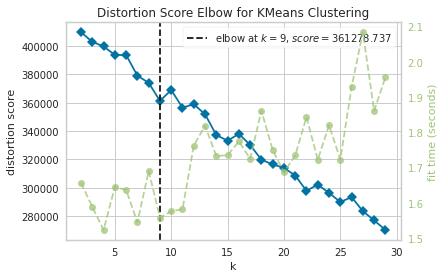

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(init='k-means++', random_state=540)
visualizer = KElbowVisualizer(km, k=(2,30))
 
visualizer.fit(standardized_data)
visualizer.show()

In [41]:
# Train a Kmeans instance
n_clusters = 9

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=540)
kmeans.fit(standardized_data)
clusters = kmeans.predict(standardized_data)
df_final['cluster'] = clusters


df_final = df_final.astype({col: 'int32' for col in df_final.select_dtypes('int64').columns})
df_final = df_final.astype({col: 'int32' for col in df_final.select_dtypes('float64').columns})
df_final = df_final.astype({col: 'int32' for col in df_final.select_dtypes('bool').columns})

df_final

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951,cluster
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

pca = PCA(n_components=2)

reduced_X = pd.DataFrame(pca.fit_transform(standardized_data), columns=["PC1", "PC2"])
reduced_X

,PC1,PC2
0,-0.486120,-0.157238
1,-0.456954,-0.209865
2,-0.479306,-0.138931
3,-0.450099,-0.144068
4,-0.496326,-0.160921
...,...,...
253,-0.460834,-0.147938
254,0.788153,-0.293305
255,-0.450099,-0.144068
256,-0.450677,-0.145385


In [43]:
reduced_X['cluster'] = clusters
reduced_X

,PC1,PC2,cluster
0,-0.486120,-0.157238,0
1,-0.456954,-0.209865,0
2,-0.479306,-0.138931,0
3,-0.450099,-0.144068,0
4,-0.496326,-0.160921,0
...,...,...,...
253,-0.460834,-0.147938,0
254,0.788153,-0.293305,0
255,-0.450099,-0.144068,0
256,-0.450677,-0.145385,0


/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


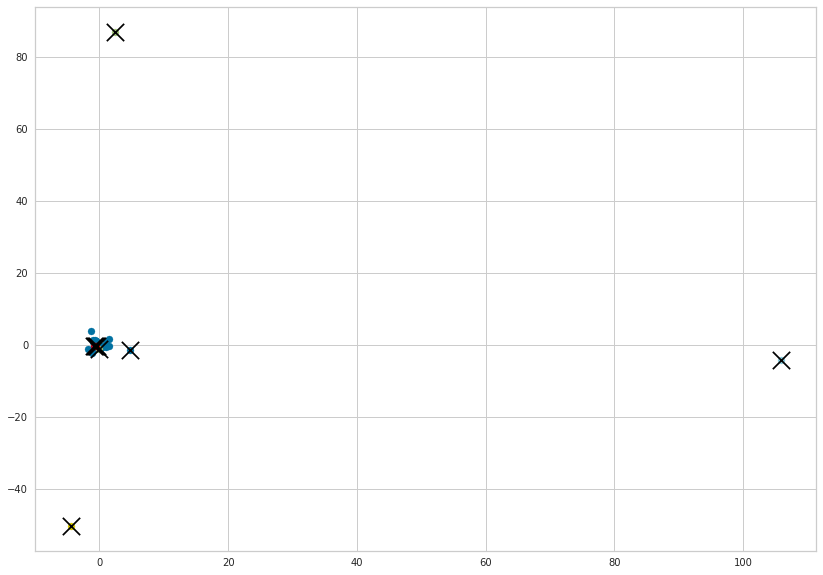

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

reduced_centers = pca.transform(kmeans.cluster_centers_)

for cluster in range(0, n_clusters):
    plt.scatter(
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC1'],
        reduced_X[reduced_X['cluster'] == cluster].loc[:, 'PC2']
    )


plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], color='black', marker='x', s=300)
plt.show()

In [45]:
reduced_centers = pca.transform(kmeans.cluster_centers_)
reduced_centers

/opt/app/.venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[-4.25158380e-01, -1.18574751e-01],
       [-9.97675865e-02, -1.06671983e+00],
       [-8.02995605e-01, -1.96617203e-01],
       [-7.20125802e-01, -2.70936352e-01],
       [-4.46277555e+00, -5.02860631e+01],
       [ 1.05887674e+02, -4.14824070e+00],
       [ 4.68406746e+00, -1.28006150e+00],
       [ 2.38395350e+00,  8.70915366e+01],
       [-5.80435914e-01, -1.99210255e-01]])

In [46]:
df_final['cluster'].value_counts()

0    250
3      1
7      1
4      1
8      1
2      1
1      1
5      1
6      1
Name: cluster, dtype: int64

In [48]:
df_final[df_final['cluster'] == 0]

trans_tittle_code_id,title_100017,title_10006,title_100191,title_100506,title_10059,title_100894,title_100961,title_101032,title_1011,title_101292,...,title_940,title_955,title_973,title_97497,title_97613,title_97649,title_9793,title_9945,title_9951,cluster
code,,,,,,,,,,,,,,,,,,,,,
199001027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199101244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199113169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199115974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200129666,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200223011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200243848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [491]:
df_final.to_csv('cluster.csv', index=True, sep='*')

In [529]:
from sklearn.tree import _tree, DecisionTreeClassifier
import pprint

pp = pprint.PrettyPrinter(indent=4)

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
                # register new rule to dictionary
                selected_class = classes[max_idx]
                class_probability = dist[max_idx]
                class_rules = class_rules_dict.get(selected_class, [])
                class_rules.append((rule_string, class_probability))
                class_rules_dict[selected_class] = class_rules

    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    return report_df
    
    # report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']]

In [397]:
df_results = cluster_report(standardized_data, clusters, min_samples_leaf=50, pruning_level=0.01)

In [398]:
pd.set_option('max_colwidth', -1)
display(df_results)

/tmp/ipykernel_2910/1650900302.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,class_name,instance_count,rule_list
0,0,269,NaN
1,3,1,NaN
2,2,1,NaN
3,1,1,NaN


In [530]:
# Library of Functions for the OpenClassrooms Multivariate Exploratory Data Analysis Course

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns


palette = sns.color_palette("bright", 10)

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)

def append_class(df, class_name, feature, thresholds, names):
    '''Append a new class feature named 'class_name' based on a threshold split of 'feature'.  Threshold values are in 'thresholds' and class names are in 'names'.'''
    
    n = pd.cut(df[feature], bins = thresholds, labels=names)
    df[class_name] = n

def plot_dendrogram(Z, names, figsize=(10,25)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    #plt.show()

def addAlpha(colour, alpha):
    '''Add an alpha to the RGB colour'''
    
    return (colour[0],colour[1],colour[2],alpha)

def display_parallel_coordinates(df, num_clusters):
    '''Display a parallel coordinates plot for the clusters in df'''

    # Select data points for individual clusters
    cluster_points = []
    for i in range(num_clusters):
        cluster_points.append(df[df.cluster==i])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 15))
    title = fig.suptitle("Parallel Coordinates Plot for the Clusters", fontsize=18)
    fig.subplots_adjust(top=0.95, wspace=0)

    # Display one plot for each cluster, with the lines for the main cluster appearing over the lines for the other clusters
    for i in range(num_clusters):    
        plt.subplot(num_clusters, 1, i+1)
        for j,c in enumerate(cluster_points): 
            if i!= j:
                pc = parallel_coordinates(c, 'cluster', color=[addAlpha(palette[j],0.2)])
        pc = parallel_coordinates(cluster_points[i], 'cluster', color=[addAlpha(palette[i],0.5)])

        # Stagger the axes
        ax=plt.gca()
        for tick in ax.xaxis.get_major_ticks()[1::2]:
            tick.set_pad(20)        


def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

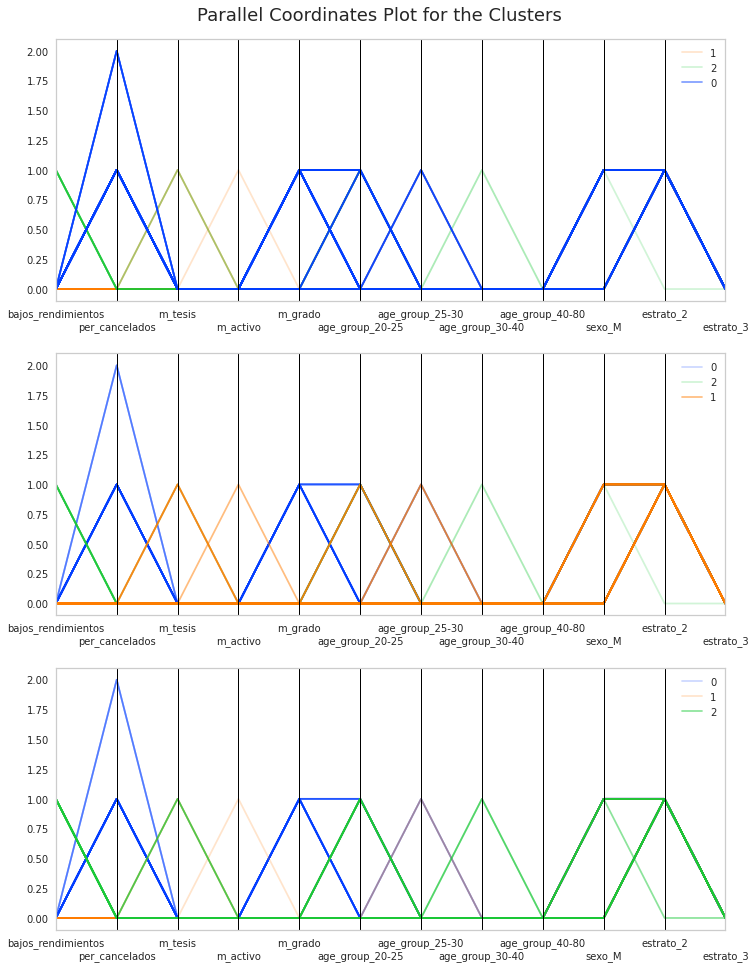

In [531]:
display_parallel_coordinates(df_final, 3)